In [1]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..

In [2]:
from src.taa.tools.data import get_strategy_price_data
from src.taa.strategy.static import STRATEGIES
from src.taa.strategy.strategies import StrategyPipeline
from src.taa.strategy.signals import Signal
from src.taa.backtest.positions import EqualWeights, RiskParity
from src.taa.backtest.performance import Tearsheet
from src.taa.backtest.returns import Backtester
from src.taa.backtest.returns import get_historical_total_return

import pandas as pd
import numpy as np

In [3]:
start, end = "2011-01-01", "2023-03-01"
rebalance_dates = pd.bdate_range(start, end, freq="BM")

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()

In [4]:
# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
weights = weights.stack().rename(strategy.tag).to_frame()

# benchmark strategies
assets = strategy.get_tickers()
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
# somethings wrong with the inverse vol date look up in risk parity...
# rp = RiskParity(assets, rebalance_dates, returns)

In [17]:
bt = Backtester(weights.merge(ew, on=["Date", "ID"]), "USD")
port_total_returns = bt.run(return_type="total")
port_price_returns = bt.run(return_type="price")
pd.concat([port_price_returns["IVY"].rename("price_ret"), port_total_returns["IVY"].rename("total_ret")], axis=1).add(1).cumprod().tail()

,price_ret,total_ret
Date,,
2022-10-31,1.770908,1.774767
2022-11-30,1.776499,1.780378
2022-12-30,1.782954,1.786879
2023-01-31,1.796619,1.800574
2023-02-28,1.766290,1.770193


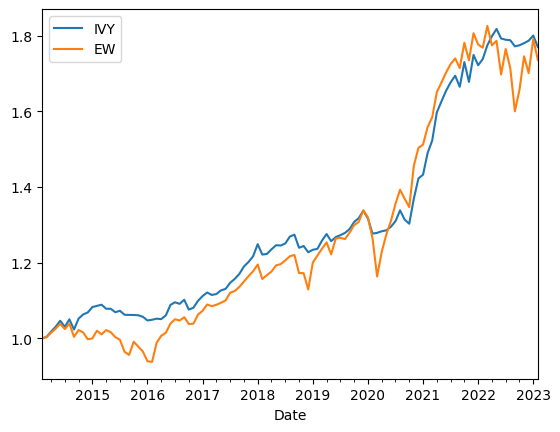

In [6]:
port_returns.add(1).cumprod().plot();

In [92]:
Tearsheet(port_returns).summary()

,IVY,EW
#obs,109.000000,109.000000
#years,13.043651,13.043651
Total Return,0.960754,0.932760
Annual. Return,0.052977,0.051817
Volatility,0.235604,0.366455
MaxDD,-0.040635,-0.118643
Skewness,-0.053954,-0.319798
Kurtosis,3.393043,3.939026
Sharpe Ratio,6.743764,4.351264
StdErr,0.294449,0.296004
